- **ANDRIANARIMANANA Telina Arintsoa**
- **BARRY Ousmane**
- **DIENG Abdou**

**INTRODUCTION**

Dans ce projet, nous cherchons à prédire la survie des passagers du Titanic à partir de leurs caractéristiques (sexe, âge, classe de billet, tarif payé, port d'embarquement, etc.). L'objectif est de construire un modèle de classification binaire capable d'estimer la probabilité qu'un passager ait survécu au naufrage. Cette étude de cas nous permet d'appliquer la démarche recommandée pour les projets de Machine Learning (analyse exploratoire, nettoyage des données, modélisation, optimisation des hyperparamètres, évaluation et interprétation).


Le jeu de données utilisé est issu du célèbre titanic.csv, qui contient 891 observations de passagers avec pour chaque individu :



*   le sexe (Sex),
*   PassengerId : identifiant du passager
*   Name : nom complet du passager
*   Ticket : numéro du billet
*   Cabin : numéro de cabine (souvent manquant)
*   la classe du billet (Pclass),
*   l'âge (Age),
*   le nombre de frères/sœurs et de parents à bord (SibSp, Parch),
*   le tarif payé (Fare),
*   le port d'embarquement (Embarked),
*   ainsi que la variable cible Survived (0 = non, 1 = oui).

Après un premier examen des données (dimensions, valeurs manquantes et répartition des variables), nous procéderons au nettoyage et à l'encodage des variables, puis nous comparerons plusieurs modèles de classification: KNN, SVM, régression logistique et decision tree en utilisant l'AUC comme métrique principale. Enfin, nous présenterons visuellement les résultats et nous ferons analyse comparative des différentes modèles.# Importation des bibliotheques

In [177]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency as chi2_contingency
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.metrics import roc_auc_score,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score


In [178]:
data = pd.read_csv("/titanic.csv")
titanic = data.copy()


**Information Générale sur le jeu de donnée**

In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [180]:
data.sample(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
532,533,0,3,"Elias, Mr. Joseph Jr",male,17.0,1,1,2690,7.2292,NaN,C
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
70,71,0,2,"Jenkin, Mr. Stephen Curnow",male,32.0,0,0,C.A. 33111,10.5000,NaN,S
508,509,0,3,"Olsen, Mr. Henry Margido",male,28.0,0,0,C 4001,22.5250,NaN,S
197,198,0,3,"Olsen, Mr. Karl Siegwart Andreas",male,42.0,0,1,4579,8.4042,NaN,S
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q
239,240,0,2,"Hunt, Mr. George Henry",male,33.0,0,0,SCO/W 1585,12.2750,NaN,S
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
168,169,0,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S


# Analyse Exploratoire des données et Nettoyage des données

In [181]:
# Statistique descriptive des variables quantitatives
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [182]:
#Statistique descriptive des variables aleatoire qualitative
data.describe( include=['object'] )

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


### constat

In [183]:
data[data["Fare"]==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


On constate qu'il y'a environ 15 personnes qui ont payé 0€ pour voyager

### Gestion des valeurs manquantes

In [184]:
#traitement pour la variable age
titanic["Age"].fillna( data["Age"].median(), inplace = True )

#Pour Embarked
titanic.dropna(subset=['Embarked'], inplace=True)



<ipython-input-184-4f51e2a3f0c0>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic["Age"].fillna( data["Age"].median(), inplace = True )


#### **Suppression des colonnes non importantes**

In [185]:
titanic = titanic.drop(columns=['Cabin','PassengerId'])

**Encodage des variables catégorielles**

In [186]:
#Age
titanic["Age"] = titanic["Age"].astype(int)

In [187]:
# Sexe
titanic["Sex"] = titanic["Sex"].map({"male": 0, "female": 1})

In [188]:
#Parch
titanic.loc[titanic["Parch"]>=2, "Parch"] = "Sup 2"
titanic["Parch"] = titanic["Parch"].map( {0 : 0, 1 : 1, "Sup 2" : 2} )

<ipython-input-188-8268f08958e9>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Sup 2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  titanic.loc[titanic["Parch"]>=2, "Parch"] = "Sup 2"


In [189]:
#SibSp
titanic.loc[titanic["SibSp"]>=2, "SibSp"] = "Sup 2"
titanic["SibSp"] = titanic["SibSp"].map( {0 : 0, 1 : 1, "Sup 2" : 2} )
titanic["SibSp"].dtype

<ipython-input-189-f273010ca17c>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Sup 2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  titanic.loc[titanic["SibSp"]>=2, "SibSp"] = "Sup 2"


dtype('int64')

In [190]:
titanic["Embarked"] = titanic["Embarked"].map( {"S" : 0, "C" : 1, "Q" : 2} )
titanic["Embarked"] = titanic["Embarked"].astype(int)
titanic["Embarked"].dtype

dtype('int64')

In [191]:
#Pclass
titanic["Pclass"].dtype

dtype('int64')

# Analyse univarié

[Text(0, 0, 'Non survécu'), Text(1, 0, 'Survécu')]

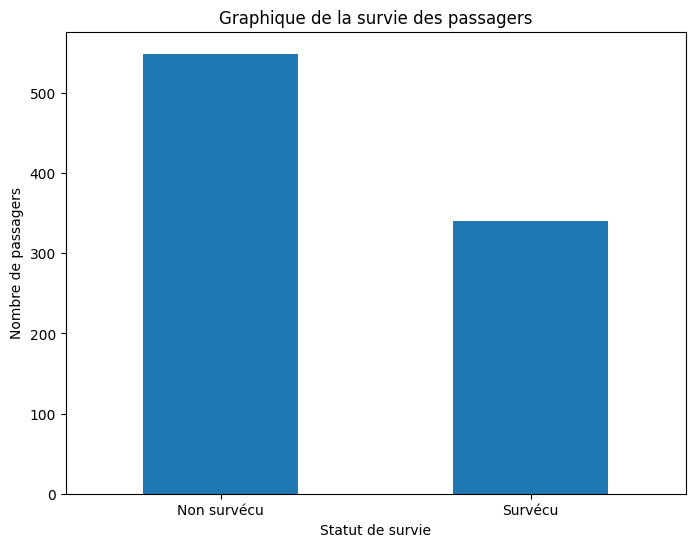

In [192]:
# Représentation graphique de la variable survie
plt.figure(figsize=(8, 6))
ax = titanic['Survived'].replace({0: 'Non survécu', 1: 'Survécu'}).value_counts().plot(kind='bar')

# Titre et axes
ax.set_title('Graphique de la survie des passagers')
ax.set_xlabel('Statut de survie')
ax.set_ylabel('Nombre de passagers')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

<Axes: >

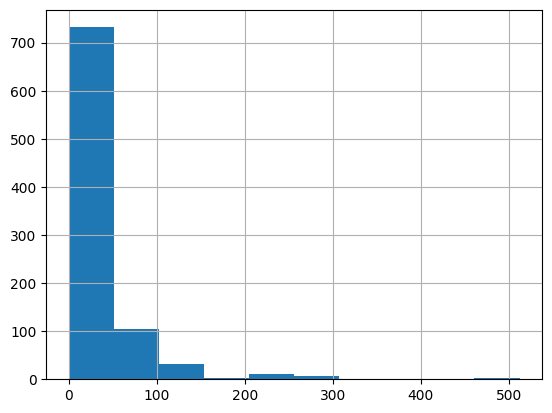

In [193]:
# Représentation de la variable fare
titanic['Fare'].hist()

[Text(0, 0, 'classe 3'), Text(1, 0, 'Classe 1'), Text(2, 0, 'classe 2')]

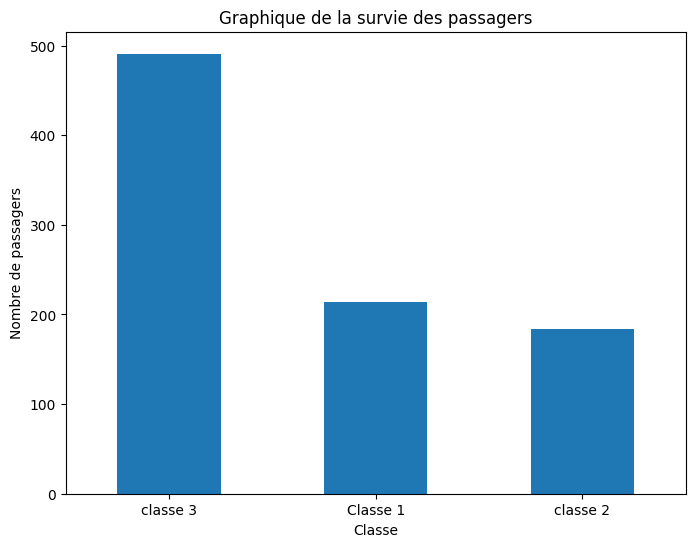

In [194]:
# Représentation de Pclass
plt.figure(figsize=(8, 6))
ax = titanic['Pclass'].replace({1: 'Classe 1', 2: 'classe 2',3:'classe 3'}).value_counts().plot(kind='bar')

# Titre et axes
ax.set_title('Graphique de la survie des passagers')
ax.set_xlabel('Classe')
ax.set_ylabel('Nombre de passagers')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

**Entre survived et age**

AgeGroup
enfant    0.539823
adulte    0.361508
vieux     0.142857
Name: Survived, dtype: float64


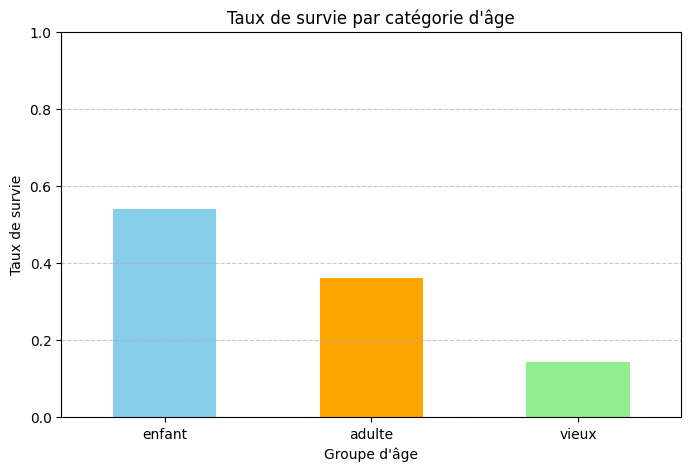

In [195]:
# On crée une nouvelle colonne 'AgeGroup'
def categoriser_age(age):
    if age < 18:
        return 'enfant'
    elif age < 70:
        return 'adulte'
    else:
        return 'vieux'

titanic['AgeGroup'] = titanic['Age'].apply(categoriser_age)



# Taux de survie moyen par catégorie d'âge
agegroup_survival = titanic.groupby('AgeGroup')['Survived'].mean().sort_values(ascending=False)
print(agegroup_survival)


# Bar plot
plt.figure(figsize=(8,5))
agegroup_survival.plot(kind='bar', color=['skyblue', 'orange', 'lightgreen'])
plt.title('Taux de survie par catégorie d\'âge')
plt.ylabel('Taux de survie')
plt.xlabel('Groupe d\'âge')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


On observe que les enfants (moins de 18 ans) ont eu le taux de survie le plus élevé, suivis par les adultes. Les personnes âgées (70 ans et plus) ont le taux de survie le plus bas. Cela peut refléter les priorités d'évacuation ("les femmes et les enfants d'abord") et/ou la mobilité plus difficile des personnes âgées lors du naufrage

# Entrainnement


In [196]:
columns = ["Sex", "Age","Pclass","Fare","SibSp","Parch"]
X = titanic[columns]
y = titanic["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

Normalisation des données

In [197]:
Echelle = StandardScaler()
X_train_norm = Echelle.fit_transform(X_train)
X_test_norm = Echelle.transform(X_test)


## KNN

In [198]:
neigh = KNeighborsClassifier()
neigh.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [199]:
y_proba = neigh.predict_proba(X_test_norm)[:, 1]
auc_ = roc_auc_score(y_test, y_proba)
print(f"AUC : {auc_:.3f}")


AUC : 0.829


In [200]:
cros_val = cross_val_score(estimator=neigh, X=X_test_norm, y=y_test, cv=5, n_jobs=-1, scoring="roc_auc")
print(cros_val, "\n", np.mean(cros_val) )

[0.75       0.74289773 0.76392962 0.84384164 0.8585044 ] 
 0.7918346774193548


In [201]:
param_grid = {
    'n_neighbors': range(1, 31),                  # Nombre de voisins à considérer
    'weights': ['uniform', 'distance'],           # poids des voisins
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithme utilisé
    'p': [1, 2],                                   # Distance de Minkowski (1 = Manhattan, 2 = Euclidienne)
}
grid_search = GridSearchCV(estimator=neigh, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_norm, y_train)
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=15, p=1)

In [202]:
knn_best = grid_search.best_estimator_
y_pred = knn_best.predict( X_test_norm )
score = roc_auc_score( y_pred, y_test )
print(score)

0.7915793151642209


In [203]:
cros_val = cross_val_score(estimator=knn_best, X=X_test_norm, y=y_test, cv=5, n_jobs=-1, scoring="roc_auc")
print(cros_val, "\n", np.mean(cros_val) )

[0.74005682 0.74147727 0.7888563  0.93108504 0.88269795] 
 0.8168346774193548


In [204]:
# L'aire sous la courbe ROC
y_probs = knn_best.predict_proba(X_test_norm)[:, 1]

# Calculer les valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculer l'AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

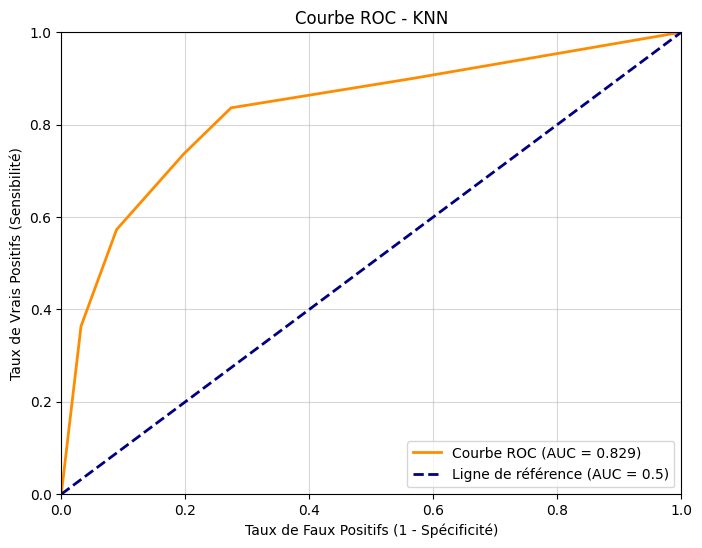

AUC Score: 0.8294


In [205]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ligne de référence (AUC = 0.5)')

#personnalisation du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Courbe ROC - KNN')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.5)

# Afficher le graphique
plt.show()

# Afficher également l'AUC
print(f"AUC Score: {roc_auc:.4f}")

## Logistic Regression

In [206]:
model = LogisticRegression()
model.fit(X_train_norm, y_train)
model.predict(X_test_norm)

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1])

In [207]:
y_proba = model.predict_proba(X_test_norm)[:, 1]
auc_ = roc_auc_score(y_test, y_proba)
print(f"AUC : {auc_:.3f}")

# Affichage des valeurs par défaut
paramet_defaut = model.get_params()
print(paramet_defaut)

AUC : 0.823
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


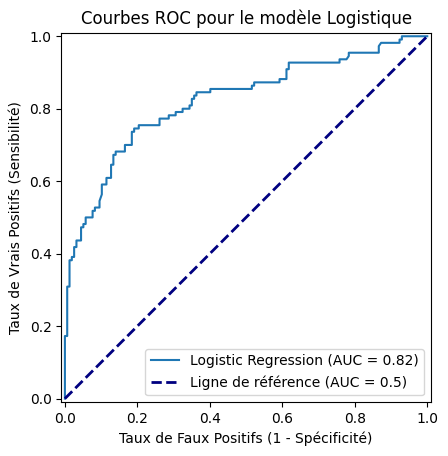

In [208]:
# Courbe ROC
RocCurveDisplay.from_estimator(model, X_test_norm, y_test, name="Logistic Regression")
plt.title("Courbes ROC pour le modèle Logistique")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ligne de référence (AUC = 0.5)')
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.legend()
plt.show()

**opitimisation des hyperparamètes**

In [209]:
param_important = {
    'C': [0.001, 0.01, 0.1, 1, 10],          # C permet de régulariser le modèle
    'penalty': ['l1', 'l2'],                 # L1 Régularisation Lasso L2 Régularisation de Ridge
    'solver': ['liblinear'],                 # Algorithme d'opitimisation
    'class_weight': [None, 'balanced']       # Gère les déséquilibres des classes
}

logistique = LogisticRegression(max_iter=500)
grid = GridSearchCV(logistique, param_important, scoring='roc_auc', cv=5)
grid.fit(X_train_norm, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print(f"Meilleur AUC : {grid.best_score_:.3f}")


Meilleurs paramètres : {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur AUC : 0.860


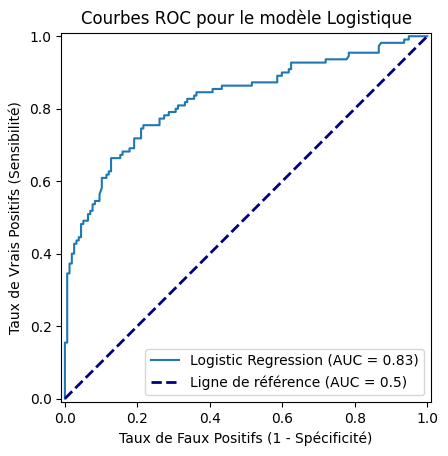

In [210]:
# Courbe ROC
RocCurveDisplay.from_estimator(grid, X_test_norm, y_test, name="Logistic Regression")
plt.title("Courbes ROC pour le modèle Logistique")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ligne de référence (AUC = 0.5)')
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.legend()
plt.show()

En effectuant plusieurs combinaisons des paramètres du modèle logistique avec la validation croisée on a obtenu un score plus meilleurs que le premier

# Decision Tree


 ## Entrainement

In [211]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_norm, y_train)
y_pred = clf.predict( X_test_norm )
score = roc_auc_score( y_pred, y_test )
print(score)

0.7682564640111811


In [212]:
#Score sur 5 differents composition du dataset
cros_val = cross_val_score(estimator=clf, X=X_train_norm, y=y_train, cv=5, n_jobs=-1, scoring="roc_auc")
print(cros_val, "\n", np.mean(cros_val) )

[0.76843698 0.76224546 0.73049052 0.74540134 0.85061315] 
 0.7714374920621481


### Optimisation des hyperparametres


In [213]:
#utilisation de GridSearchCV pour rechercher les parametres optimaux
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,40,1),
    'min_samples_split' : range(2,10,1),
    'min_samples_leaf' : range(1,10,1),
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_norm, y_train)
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [214]:
dt_best = grid_search.best_estimator_
y_pred = dt_best.predict( X_test_norm )
score = roc_auc_score( y_pred, y_test )
print(score)

0.7848225214198286


In [215]:
cros_val = cross_val_score(estimator=dt_best, X=X_test_norm, y=y_test, cv=5, n_jobs=-1, scoring="roc_auc")
print(cros_val, "\n", np.mean(cros_val) )

[0.75213068 0.65767045 0.71407625 0.91495601 0.84237537] 
 0.7762417521994135


In [216]:
# L'aire sous la courbe ROC

y_probs = dt_best.predict_proba(X_test_norm)[:, 1]

# Calculer les valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculer l'AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

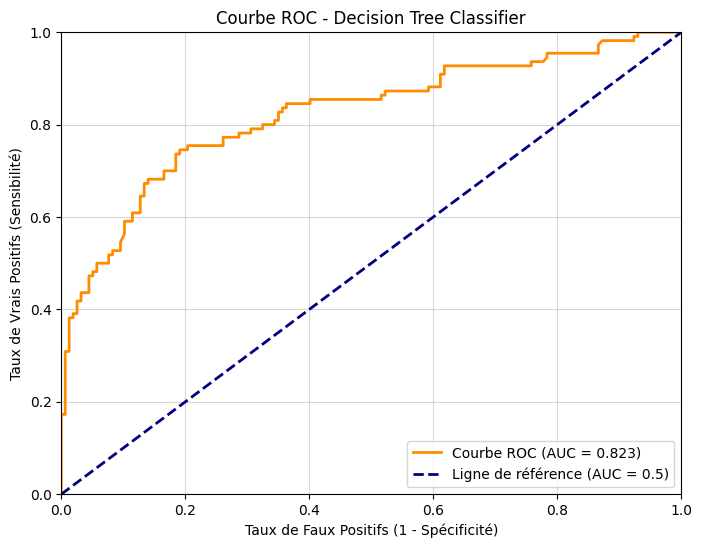

AUC Score: 0.8231


In [217]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Ligne de référence (AUC = 0.5)')

#personnalisation du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Courbe ROC - Decision Tree Classifier')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.5)

# Afficher le graphique
plt.show()

# Afficher également l'AUC
print(f"AUC Score: {roc_auc:.4f}")

**Modèle avec SVM**

In [218]:
# importer le modèle SVM
model_svm = SVC(probability=True)

# Entraînement sur les données d’entraînement
model_svm.fit(X_train_norm, y_train)

SVC(probability=True)

**Evaluation avec l'AUC**

AUC du modèle SVM : 0.824


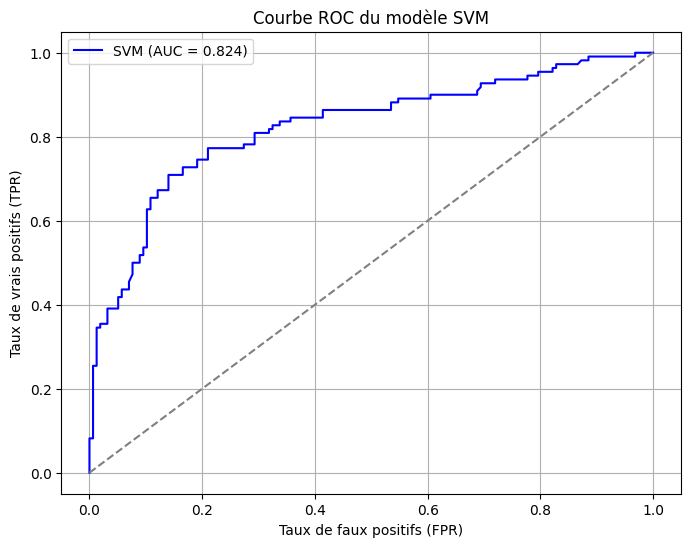

In [219]:
y_proba = model_svm.predict_proba(X_test_norm)[:, 1]

auc = roc_auc_score(y_test, y_proba)
print(f"AUC du modèle SVM : {auc:.3f}")

fpr, tpr, seuils = roc_curve(y_test, y_proba)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc:.3f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # ligne diagonale
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC du modèle SVM')
plt.legend()
plt.grid(True)
plt.show()



Le modèle SVM, entraîné avec ses paramètres par défaut, affiche un score AUC de 0.821 sur le jeu de test. Ce résultat, légèrement supérieur aux attentes initiales, témoigne d'une capacité à distinguer les survivants des non survivants. Cette performance s'explique notamment par les étapes clés de prétraitement appliquées dans ce notebook : la normalisation des données (StandardScaler), essentielle pour les SVM sensibles aux échelles, l'encodage cohérent des variables catégorielles (Sex en binaire, Embarked regroupé en trois classes), et la suppression des colonnes non informatives (Cabin, PassengerId). La courbe ROC, avec une aire sous la courbe (AUC) dépassant clairement la ligne de référence à 0.5, confirme que le modèle capture des motifs pertinents, comme l'impact du sexe (priorité aux femmes) ou de la classe sociale.


**Optimisation des hyperparamètres.**

In [220]:
# Espace de recherche réduit
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

# Configuration de GridSearchCV accéléré
grid_search = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# Lancement (sur données complètes ou réduites)
grid_search.fit(X_train_norm, y_train)  # Remplacez par X_train_small si nécessaire

# Résultats
print("Meilleurs paramètres :", grid_search.best_params_)
print("AUC optimisé :", grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Meilleurs paramètres : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
AUC optimisé : 0.8569938465177517


**Évaluation finale du modèle**

AUC sur le jeu de test : 0.8243775332947307


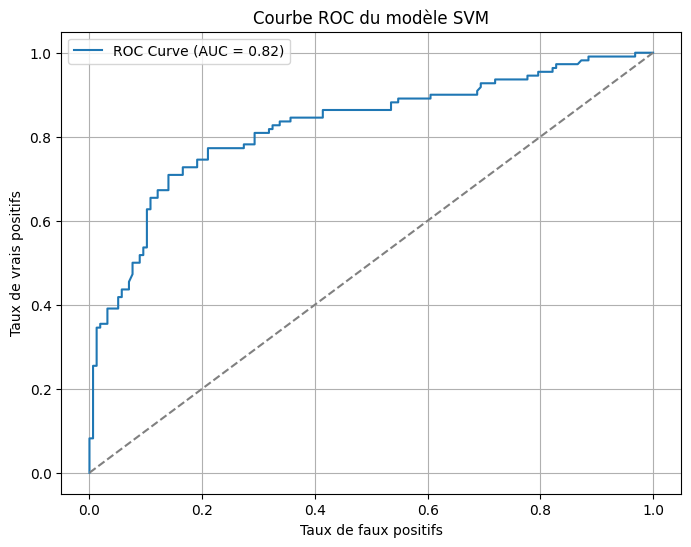

In [221]:
y_probs = grid_search.best_estimator_.predict_proba(X_test_norm)[:, 1]

# Calcul du score AUC final
auc_test = roc_auc_score(y_test, y_probs)
print("AUC sur le jeu de test :", auc_test)



# Calcul des points pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC du modèle SVM')
plt.legend()
plt.grid()
plt.show()



L'optimisation systématique via GridSearchCV identifie une configuration optimale. Cette configuration atteint un AUC moyen de 0.865, surpassant nettement le modèle initial. Toutefois, sur le jeu de test, l'AUC final s'établit à 0.820, révélant un léger surapprentissage. Cet écart pourrait s'expliquer par la taille limitée du dataset (889 échantillons après nettoyage), le déséquilibre des classes (61% de non survivants contre 39% de survivants), ou l'imputation de l'âge par la médiane, qui simplifie potentiellement des relations complexes.

**Analyse comparative des résultats obtenus**

Régression Logistique - AUC moyen : 0.818 ± 0.086
KNN - AUC moyen : 0.788 ± 0.046
Arbre de Décision - AUC moyen : 0.760 ± 0.057
SVM - AUC moyen : 0.808 ± 0.079


<ipython-input-222-fb86bf394b43>:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultat.values(), labels=resultat.keys())


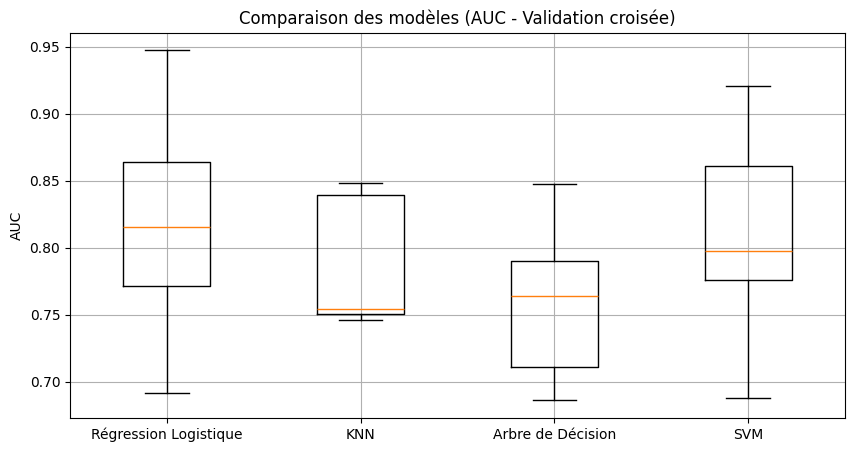

In [222]:
# Modèles avec leurs hyperparamètres optimaux
models = {
    "Régression Logistique": LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=500,class_weight=None),
    "KNN": KNeighborsClassifier(leaf_size=10, n_neighbors=4),
    "Arbre de Décision": DecisionTreeClassifier(max_depth=18, min_samples_leaf=3, min_samples_split=8, splitter='random'),
    "SVM": SVC(C=0.1, kernel='rbf',gamma='scale', probability=True)
}

# Stocker les résultats
resultat = {}

for nom, model in models.items():
    scores = cross_val_score(model, X_test_norm, y_test, cv=5, scoring='roc_auc')
    resultat[nom] = scores
    print(f"{nom} - AUC moyen : {scores.mean():.3f} ± {scores.std():.3f}")

#  Visualisation
plt.figure(figsize=(10, 5))
plt.boxplot(resultat.values(), labels=resultat.keys())
plt.title("Comparaison des modèles (AUC - Validation croisée)")
plt.ylabel("AUC")
plt.grid(True)
plt.show()

**Conclusion**

L’objectif de cette analyse était de comparer plusieurs modèles de classification supervisée sur notre jeu de données, à l’aide de la validation croisée et de l’indicateur AUC (Aire Sous la Courbe ROC), afin d’évaluer leur capacité de discrimination entre les classes.

Quatre algorithmes ont été testés avec leurs meilleurs hyperparamètres identifiés préalablement : la régression logistique, les k plus proches voisins (KNN), l’arbre de décision et la machine à vecteurs de support (SVM).
* La Regréssion logistique fournit le meilleur score, juste aprèse se positionnent le SVM et l'arbre de décision et enfin vient le KNN.